# Análisis y preprocesamiento del corpus *El País*

In [1]:
%env CORPUS=../input/el_pais/elpais20140926203240Noticias.largexml

env: CORPUS=../input/el_pais/elpais20140926203240Noticias.largexml


In [2]:
# tamano
!ls -lSr --block-size=M $CORPUS

-rw-rw-r-- 1 jp jp 2245M oct 18 16:02 ../input/el_pais/elpais20140926203240Noticias.largexml


In [3]:
# estructura
!head -n2 $CORPUS

Notar como el archivo empieza con un `<add>`; sin embago esta etiqueta nunca es cerrada con un `</add>`.

In [4]:
!cat $CORPUS | grep "<add>"

In [5]:
!cat $CORPUS | grep "</add>"

Debido a esto, resulta conveniente ignorar los primeros 5 caracteres, ya que lo único que hacen es estorbar.

Notar que el archivo se organiza en `<doc> ... </doc>`

In [6]:
!head -n20 $CORPUS | cut -c -80


<field name="url">http://historico.elpais.com.uy/Suple/EconomiaYMercado/10/04/12
<field name="articulo">RACHA | Acumuló la tercera semana consecutiva de descens
<field name="title">Dólar con vaivenes - Diario EL PAIS - Montevideo - Uruguay<








<field name="url">http://historico.elpais.com.uy/Suple/EconomiaYMercado/10/05/10
<field name="articulo">Los efectos de la trampa del euro PAUL KRUGMAN | DESDE NU
<field name="title">Los efectos de la trampa del euro - Diario EL PAIS - Montevi







De cuantas lineas se compone el corpus?

In [7]:
!cat $CORPUS | wc -l

5988917


De cuantos artículos se compone el corpus?

In [8]:
!grep -o '</doc>' $CORPUS | wc -l

544447


In [9]:
import io
import random

from tqdm.auto import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

total_lines = 5_988_917
total_docs  = 544_447

In [10]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:           7831        2111         136         306        5583        5131
Swap:          3905          20        3885


In [11]:
pth = '/home/jp/Workspace/pln/news-processor/input/el_pais/elpais20140926203240Noticias.largexml'
end_patt = '</doc>'
counter = 0
with io.open(pth,'r', encoding='utf8') as f:
    for line in tqdm(f):
        line = line.rstrip('\n')
        if line == end_patt:
            counter += 1
counter

0it [00:00, ?it/s]

544447

Consumo de memoria?

In [12]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:           7831        2112         133         308        5585        5128
Swap:          3905          20        3885


we good.

A modo de buffer, vamos a **1.leer ➡️ 2. parsear ➡️ 3. procesar ➡️ 4. escribir** doc-by-doc, evitando así utilizar *gigas upon gigas* de memoria.

## Muestro aletorio de artículos

### Observaciones

* el `241506` son como tres noticias en 1? notar que `|` funciona como una especie de separador de nocias por lo que tal vez, sería conveniente reemplazarlo por `\n\n`
* el `129808` termina en "Vota por esta noticia:"
* el `447094` es cualquier cosa. El artículo parecería terminar justo antes de `:: Último Momento ::`
* notar que el artículo #1 tambíen tiene como esos "artículos de más" sobre el pie de página. La sequencia ` :: ` parecería ser un indicador.
* el `40758` contiene un link malformado (con un espacio) `http:// dragonage.bioware.com`
* el `240310` contiene caracteres `�`, es una noticia de deportes y ademas contiene el título mismo de la noticia en el artículo mismo. Notar que el título de la noticia está en mayúsculas.

In [26]:
parse        = lambda raw: BeautifulSoup(raw, features="lxml")
get_articulo = lambda doc: doc.find("field", {"name" : "fecha"}).text
get_fecha    = lambda doc: doc.find("field", {"name" : "fecha"}).text
# 
corrupto = lambda art: '�' in art

In [13]:
""" esta funcion lo que samplear un artículo 
aleatorio del corpus. Retorna el `idx` del 
artículo sampleado + el artículo en sí
"""
def sample():
    art, counter, rix = '', 0, random.randrange(total_docs)
    with io.open(pth,'r', encoding='utf8') as f:
        # de la primera linea omito el `<add>`
        line = next(f)
        art += line[len('<add>'):]
        # el resto
        for line in tqdm(f, total=total_lines-1):
            line = line.rstrip('\n')
            art += line + "\n"
            if line == end_patt:
                if counter == rix: return rix, art;
                counter += 1
                art = ''

In [16]:
aix, rart = sample()
print(aix, get_articulo(parse(rart)))

  0%|          | 0/5988916 [00:00<?, ?it/s]

252480 <html><body><doc>
<field name="url">http://historico.elpais.com.uy/02/12/29/pciuda_24612.asp</field>
<field name="articulo">RENOVACION I El concesionario realizar� una inversi�n de 55 millones de d�lares entre la obra civil y cinco centros de entretenimiento en Montevideo y Canelones Maro�as reabrir� el 15 de marzo El Gran Premio Ram�rez que portradici�n se corre los 6 de enero podr�a trasladarse para la inauguraci�n ANTONIO ALVAREZ Como buen jockey, Fabio Guede sue�a con la recta final. Atr�s van quedando los palos blancos, las chaquetas de seda desti��ndose al viento, los gritos desde la tribuna llenos de palabras incomprensibles. El animal responde con adrenalina, corriendo por el lado de afuera. Saca un cuerpo, dos, tres, cuatro de ventaja. Lo extra�o es que la pista no termina nunca, la carrera jam�s llega a su fin pese a que corre, corre, corre. Es una pesadilla recurrente en la vida de Guede. Y se parece bastante a los �ltimos cinco a�os del Hip�dromo de Maro�as. Con apen

Cuantos artículos contienen el caracter raro `�`

In [17]:
art, counter = '', 0
with io.open(pth,'r', encoding='utf8') as f:
    art += next(f)[len('<add>'):]
    for line in tqdm(f, total=total_lines-1):
        line = line.rstrip('\n')
        art += line + "\n"
        if line == end_patt:
            art = parse(art)
            counter += corrupto(art)
            art = ''
counter

  0%|          | 0/5988916 [00:00<?, ?it/s]

0

In [28]:
73437 / total_docs

0.13488365258693683

13.4% de los artículos tienen los caracteres raros 🤷

In [19]:
# def parse(art):
#     art = BeautifulSoup(art, features="lxml")
#     art = art.find("field", {"name" : "articulo"}).text
#     return art

In [20]:
def proc(raw):
    doc = parse(raw)
    art  = get_articulo(doc)
    print(art)
    print("-" * 80)

In [21]:
limit = 2
art, counter = '', 0

with io.open(pth,'r', encoding='utf8') as f:
    art += next(f)[len('<add>'):]
    # el resto
    for line in tqdm(f, total=total_lines-1):
        line = line.rstrip('\n')
        art += line + "\n"
        if line == end_patt:
            counter += 1
            print(counter)
            # proc(art)
            print(art)
            if counter == limit: break;
            art = ''

  0%|          | 0/5988916 [00:00<?, ?it/s]

1
<doc>
<field name="url">http://historico.elpais.com.uy/Suple/EconomiaYMercado/10/04/12/ecoymer_481874.asp</field>
<field name="articulo">RACHA | Acumuló la tercera semana consecutiva de descensos Dólar con vaivenes El billete verde se movió con marcadas oscilaciones a lo largo de la semana pasada, en la que registró descensos en tres de las cinco jornadas, para luego recuperar parte de lo perdido en las restantes dos. El viernes, el dólar interbancario fondo se operó a un promedio de $ 19,314, lo que supuso un descenso semanal de 0,71%. En lo que va de 2010 la caída acumulada llega al 1,59%. En tanto, el Banco República redujo 0,76% la pizarra entre lunes y viernes hasta $ 19,00 y $ 19,60 en cada punta. La divisa tuvo dos tendencias muy claras la semana pasada. Primero se movió a la baja, presionada por la constante búsqueda de pesos, a lo que se le sumó la mayor inflación a la esperada en marzo. Sin embargo, la tónica cambió el miércoles y jueves, con fuertes compras del BROU y de b

Distribución de las fechas

In [24]:
# limit = 100
art, counter = '', 0
dist = dict()

with io.open(pth,'r', encoding='utf8') as f:
    art += next(f)[len('<add>'):]
    for line in tqdm(f, total=total_lines-1):
        line = line.rstrip('\n')
        art += line + "\n"
        if line == end_patt:
            counter += 1
            art = parse(art)
            year = get_fecha(art)[:4]
            if year not in dist: dist[year] = 0
            dist[year] += 1
            #if counter == limit: break;
            art = ''
            
dist

  0%|          | 0/5988916 [00:00<?, ?it/s]

{'2010': 29733,
 '2005': 32332,
 '2006': 45385,
 '2007': 37312,
 '2008': 34938,
 '2003': 48454,
 '2004': 20260,
 '2002': 18533,
 '2009': 13028,
 '2014': 102474,
 '2013': 60612,
 '2011': 54543,
 '2015': 517,
 '2012': 41407,
 '2000': 601,
 '2001': 957,
 '1990': 1469,
 '2018': 594,
 '2017': 340,
 '2016': 524,
 '2019': 434}

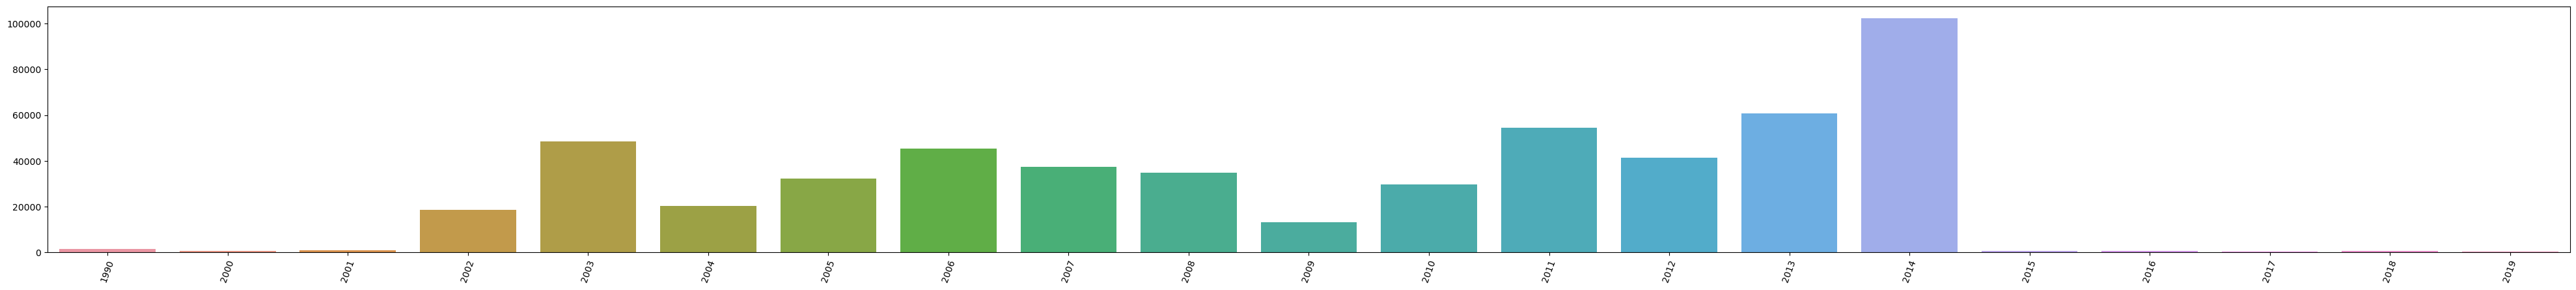

In [25]:
fig, ax = plt.subplots(figsize=(50, 5), dpi=100)
lists = sorted(dist.items())
X, Y = zip(*lists)
sns.barplot(x=list(X), y=list(Y), ax=ax)
plt.xticks(rotation=70)
plt.show()